# Подготовка

In [49]:
#Импортируем необходимые модули из DEAP и еще несколько вспомогательных библиотек:

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Объявляем несколько констант, содержащих значения параметров самой задачи и генетического алгоритма:

# константы задачи
ONE_MAX_LENGTH = 100  # длина подлежащей оптимизации битовой строки

# константы генетического алгоритма
POPULATION_SIZE = 200  # количество индивидуумов в популяции
P_CROSSOVER = 0.9  # вероятность скрещивания
P_MUTATION = 0.1  # вероятность мутации индивидуума
MAX_GENERATIONS = 50  # максимальное количество поколений

In [51]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#Впоследствии эти строки нужно будет удалить, чтобы при разных прогонах получались разные результаты.

In [52]:
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [53]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

D:\&&&\My-projects\python\PyCharm\general_ml\venv\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [54]:
creator.create("Individual", list, fitness=creator.FitnessMax)

D:\&&&\My-projects\python\PyCharm\general_ml\venv\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [55]:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

In [56]:
#Последний аргумент initRepeat – количество генерируемых объектов – здесь не задан. Это означает, что при использовании оператора populationCreator
#мы должны будем указать этот аргумент, т. е. задать размер популяции:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [57]:
def oneMaxFitness(individual):
    return sum(individual),  # вернуть кортеж

#значения приспособленности в DEAP представлены кортежами, поэтому если возвращается всего одно значение, то после него нужно поставить запятую.

In [58]:
toolbox.register("evaluate", oneMaxFitness)

In [59]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0 / ONE_MAX_LENGTH)

In [75]:
1.0 / ONE_MAX_LENGTH * 100

1.0

# Эволюция решения

Реализуем Генетический алгоритм в функции main() и поясним его шаги ниже.

In [60]:
def main():
    #Создаем начальную популяцию оператором populationCreator, задавая размер популяции POPULATION_SIZE. Также инициализируем переменную generationCounter, которая понадобится нам позже:
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0

    #Для вычисления приспособленности каждого индивидуума в начальной популяции воспользуемся функцией map(), которая применяет оператор evaluate к каждому элементу популяции.
    #Поскольку оператор evaluate – это псевдоним функции oneMaxFitness(), получающийся итерируемый объект содержит вычисленные значения приспособленности каждого индивидуума.
    fitnessValues = list(map(toolbox.evaluate, population))

    #Поскольку элементы списка fitnessValues взаимно однозначно соответствуют элементам популяции (представляющей собой список индивидуумов), мы можем воспользоваться функцией zip(), чтобы
    #объединить их попарно, сопоставив каждому индивидууму его приспособленность:
    for individual, fitnessValue in zip(population, fitnessValues):
        individual.fitness.values = fitnessValue

    #Далее, так как в нашем случае имеет место приспособляемость всего с одной целью, то извлекаем первое значение из каждого кортежа приспособленности для сбора статистики:
    fitnessValues = [individual.fitness.values[0] for individual in population]

    #В качестве статистики мы собираем максимальное и среднее значение приспособленности в каждом поколении. Для этого нам понадобятся два списка:
    maxFitnessValues = []
    meanFitnessValues = []

    #Напишем главный цикл алгоритма. В самом начале цикла проверяются условия остановки. Одно из них – ограничение на количество поколений,
    #второе – проверка на лучшее возможное решение (двоичная строка из одних единиц), после чего обновляется счетчик количества поколений:
    while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATIONS:
        generationCounter = generationCounter + 1

        #Далее применим – генетические операторы. Сначала – оператор отбора toolbox.select, который был определен как турнирный отбор.
        #Поскольку размер турнира был задан в определении оператора, сейчас нам осталось передать только популяцию и ее размер:
        offspring = toolbox.select(population, len(population))

        #Далее отобранные индивидуумы, которые находятся в списке offspring, клонируются, чтобы можно было применить к ним следующие генетические операторы, не затрагивая исходную популяцию:
        offspring = list(map(toolbox.clone, offspring))

        #Следующий генетический оператор – скрещивание. Ранее мы определили его в атрибуте toolbox.mate как псевдоним одноточечного скрещивания.
        #Мы воспользуемся встроенной в Python операцией среза, чтобы объединить в пары каждый элемент списка offspring с четным индексом со следующим за ним элементом с нечетным индексом.
        #Затем с помощью функции random() мы «подбросим монету» с вероятностью, заданной константой P_CROSSOVER, и тем самым решим, применять к паре индивидуумов скрещивание или оставить их так.
        #После удалим значения приспособленности потомков, потому что они были модифицированы и старые значения уже не актуальны:
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                #функция mate принимает двух индивидуумов и модифицирует их на месте, т. е. присваивать им новые значения не нужно.

        #Последний генетический оператор – мутация, ранее мы определили его в атрибуте toolbox.mutate как псевдоним инвертирования бита.
        #Мы должны обойти всех потомков и применить оператор мутации с вероятностью P_MUTATION.
        #Если индивидуум подвергся мутации, то нужно удалить значение его приспособленности (если оно существует), поскольку оно могло быть перенесено из предыдущего поколения:
        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        #Те индивидуумы, к которым не применялось ни скрещивание, ни мутация, остались неизменными, поэтому их приспособленности, вычисленные в предыдущем поколении, не нужно заново пересчитывать.
        #В остальных индивидуумах значение приспособленности будет пустым. Мы находим этих индивидуумов, проверяя свойство valid класса Fitness, после чего вычисляем новое значение приспособленности:
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
        for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
            individual.fitness.values = fitnessValue

        #После того как все генетические операторы применены, нужно заменить старую популяцию новой:
        population[:] = offspring

        #Прежде чем переходить к следующей итерации, учтем в статистике текущие значения приспособленности.
        #Поскольку приспособленность представлена кортежем (из одного элемента), необходимо указать индекс [0]:
        fitnessValues = [ind.fitness.values[0] for ind in population]

        #Далее мы вычисляем максимальное и среднее значения, помещаем их в накопители и печатаем сводную информацию:
        maxFitness = max(fitnessValues)
        meanFitness = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitness)
        meanFitnessValues.append(meanFitness)
        print("- Поколение {}: Макс приспособ. = {}, Средняя приспособ. = {}".format(generationCounter, maxFitness,
                                                                                     meanFitness))

        #Дополнительно мы находим индекс (первого) лучшего индивидуума, пользуясь только что найденным значением приспособленности, и распечатываем этого индивидуума:
        best_index = fitnessValues.index(max(fitnessValues))
        print("Лучший индивидуум = ", *population[best_index], "\n")

    #После срабатывания условий остановки накопители статистики можно использовать для построения двух графиков с помощью библиотеки matplotlib.
    #Во фрагменте кода ниже рисуется график изменения лучшей и средней приспособленности:
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Поколение')
    plt.ylabel('Макс/средняя приспособленность')
    plt.title('Зависимость максимальной и средней приспособленности от поколения')
    plt.show()

- Поколение 1: Макс приспособ. = 65.0, Средняя приспособ. = 53.575
Лучший индивидуум =  1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 56.855
Лучший индивидуум =  1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 3: Макс приспособ. = 69.0, Средняя приспособ. = 59.42
Лучший индивидуум =  1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 

- Поколение 4: Макс приспособ. = 70.0, Средняя приспособ. = 62.03
Лучший индивидуум =  1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 

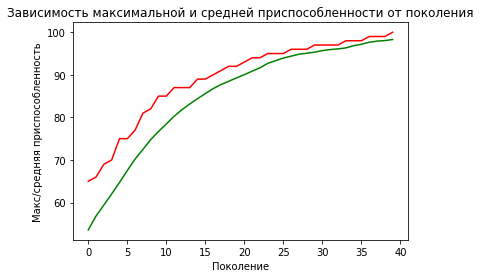

In [61]:
main()

# Ответ на решение задачи

В результате работы программы должно получиться, что после смены 40 поколений находится решение, содержащее только единицы, для которого приспособленность равна 100. После этого алгоритм останавливается. Начальное значение средней приспособленности равняется примерно 53, конечное – 100.

График должен отразить, что максимальная приспособленность возрастает скачкоообразно, а средняя – плавно.

# Применение встроенных функций

In [62]:
# Задайте функцию, которая извлекает приспособленность каждого индивидуума:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

In [63]:
# Зарегистрируйте функции, применяемые к этим значениям на каждом шаге.
# В нашем примере это функции NumPy max и mean:
stats.register("avg", numpy.mean)
stats.register("max", numpy.max)

In [64]:
# Теперь обратитесь к методу algorithms.eaSimple,
# одному из встроенных в DEAP эволюционных алгоритмов.
# Этому методу передаются популяция, toolbox, объект
# статистики и другие параметры:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS,
                                          stats=stats, verbose=True)

gen	nevals	avg  	max
0  	200   	49.33	64 
1  	179   	54.075	63 
2  	187   	57.095	67 
3  	182   	60.595	71 
4  	182   	63.78 	73 
5  	177   	66.535	74 
6  	193   	68.98 	75 
7  	186   	71.37 	78 
8  	182   	73.4  	81 
9  	185   	75.42 	82 
10 	179   	77.565	82 
11 	178   	79.005	83 
12 	176   	80.505	85 
13 	181   	81.935	89 
14 	181   	83.48 	89 
15 	184   	84.96 	91 
16 	184   	86.42 	92 
17 	184   	87.96 	92 
18 	183   	89.215	93 
19 	175   	90.47 	95 
20 	179   	91.54 	95 
21 	182   	92.525	96 
22 	192   	93.415	97 
23 	176   	94.475	97 
24 	188   	95.34 	98 
25 	180   	96.165	98 
26 	184   	96.78 	98 
27 	182   	97.32 	98 
28 	188   	97.6  	99 
29 	188   	97.905	99 
30 	190   	97.94 	99 
31 	190   	98    	99 
32 	184   	98.115	99 
33 	184   	98.44 	99 
34 	189   	98.78 	99 
35 	180   	98.915	99 
36 	185   	98.925	99 
37 	189   	98.915	99 
38 	186   	98.87 	99 
39 	180   	98.93 	99 
40 	189   	98.92 	99 
41 	181   	98.86 	99 
42 	185   	98.925	99 
43 	177   	98.9  	99 
44 	185   	9

Метод algorithms.eaSimple предполагает,
что в toolbox уже зарегистрированы операторы
evaluate, select, mate и mutate.
Условие остановки задается с помощью параметра
ngen – максимального количества поколений.

In [65]:
# Метод algorithms.eaSimple возвращает два объекта – конечную популяцию
# и объект logbook, содержащий собранную статистику.
# Интересующую нас статистику можно извлечь методом select() и
# использовать для построения графиков, как и раньше:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

In [66]:
# Определите константу, равную количеству индивидуумов,
# которые хотите хранить в зале славы:
HALL_OF_FAME_SIZE = 10

In [67]:
# Прежде чем вызывать алгоритм eaSimple, создайте объект HallOfFame такого размера:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [68]:
# Объект HallOfFame передается алгоритму eaSimple,
# который самостоятельно обновляет его в процессе выполнения генетического алгоритма:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS,
                                          stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg   	max
0  	0     	98.875	100
1  	175   	98.94 	100
2  	184   	98.965	100
3  	185   	99.05 	100
4  	180   	99.19 	100
5  	178   	99.405	100
6  	181   	99.74 	100
7  	177   	99.875	100
8  	189   	99.885	100
9  	187   	99.96 	100
10 	173   	99.93 	100
11 	187   	99.905	100
12 	182   	99.95 	100
13 	185   	99.925	100
14 	178   	99.905	100
15 	185   	99.9  	100
16 	169   	99.895	100
17 	175   	99.91 	100
18 	173   	99.91 	100
19 	181   	99.89 	100
20 	185   	99.91 	100
21 	177   	99.91 	100
22 	188   	99.865	100
23 	184   	99.86 	100
24 	185   	99.885	100
25 	179   	99.885	100
26 	182   	99.93 	100
27 	189   	99.895	100
28 	186   	99.885	100
29 	182   	99.89 	100
30 	183   	99.8  	100
31 	179   	99.985	100
32 	162   	99.935	100
33 	184   	99.915	100
34 	182   	99.895	100
35 	180   	99.9  	100
36 	171   	99.85 	100
37 	182   	99.895	100
38 	185   	99.875	100
39 	182   	99.905	100
40 	178   	99.835	100
41 	180   	99.89 	100
42 	179   	99.915	100
43 	183   	99.88 	100
44 	184   

In [73]:
# По завершении алгоритма атрибут items объекта HallOfFame можно
# использовать для доступа к списку помещенных в зал славы индивидуумов:
print("Индивидуумы в зале славы = ", *hof.items, sep="\n")
print("Лучший индивидуум = \n", hof.items[0])


Индивидуумы в зале славы = 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,